<a href="https://colab.research.google.com/github/delmonicho/torchvision_instance_segmentation/blob/main/torchvision_panda_instance_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TorchVision Instance Segmentation Finetuning Tutorial

For this tutorial, we will be finetuning a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model in the [*Penn-Fudan Database for Pedestrian Detection and Segmentation*](https://www.cis.upenn.edu/~jshi/ped_html/). It contains 170 images with 345 instances of pedestrians, and we will use it to illustrate how to use the new features in torchvision in order to train an instance segmentation model on a custom dataset.

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In [1]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-fi4nt4xo
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-fi4nt4xo
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp38-cp38-linux_x86_64.whl size=421077 sha256=0155b53c1b7b413798e59d783841bd46a6d5b599c6fc150fc19d7977224ea50d
  Stored in directory: /tmp/pip-ephem-wheel-cache-c3ry_l3k/wheels/56/da/49/cb71a7c450b59588934077f431100c05fbde50646ee84a8d40
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.6
    Uninstalling pycocotools-2.0.

## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.


One note on the labels. The model considers class 0 as background. If your dataset does not contain the background class, you should not have 0 in your labels. For example, assuming you have just two classes, cat and dog, you can define 1 (not 0) to represent cats and 2 to represent dogs. So, for instance, if one of the images has both classes, your labels tensor should look like [1,2].

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


### Writing a custom dataset for Penn-Fudan

Let's write a dataset for the Penn-Fudan dataset.

First, let's download and extract the data, present in a zip file at https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

In [2]:
%%shell

wget https://raw.githubusercontent.com/openimages/dataset/master/downloader.py
# download the Penn-Fudan dataset
# wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
#u nzip PennFudanPed.zip

--2023-03-07 16:08:06--  https://raw.githubusercontent.com/openimages/dataset/master/downloader.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4244 (4.1K) [text/plain]
Saving to: ‘downloader.py’

downloader.py       100%[===================>]   4.14K  --.-KB/s    in 0s      

2023-03-07 16:08:06 (65.4 MB/s) - ‘downloader.py’ saved [4244/4244]



In [3]:
pip install tensorflow torch torchvision umap-learn fiftyone

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.8/37.8 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [4]:
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.utils.labels as foul
import numpy as np

Migrating database to v0.19.1


INFO:fiftyone.migrations.runner:Migrating database to v0.19.1


In [5]:
# Customize where zoo datasets are downloaded
fo.config.dataset_zoo_dir = "/content"

In [6]:
dataset = fo.zoo.load_zoo_dataset(
              "open-images-v7",
              split="train",
              label_types=["segmentations"],
              classes=["Panda"],
              label_field="instances",
              max_samples=1000,
          )

INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/content/open-images-v7/train' if necessary


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv' to '/content/open-images-v7/train/metadata/image_ids.csv'


 100% |██████|    4.8Gb/4.8Gb [30.4s elapsed, 0s remaining, 179.1Mb/s]      


INFO:eta.core.utils: 100% |██████|    4.8Gb/4.8Gb [30.4s elapsed, 0s remaining, 179.1Mb/s]      


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv' to '/content/open-images-v7/train/metadata/classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/classes-segmentation.txt' to '/content/open-images-v7/train/metadata/segmentation_classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json' to '/tmp/tmpwqyaq7o9/metadata/hierarchy.json'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-annotations-object-segmentation.csv' to '/content/open-images-v7/train/labels/segmentations.csv'


Only found 350 (<1000) samples matching your requirements


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-0.zip' to '/content/open-images-v7/train/labels/masks/0.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-7.zip' to '/content/open-images-v7/train/labels/masks/7.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-6.zip' to '/content/open-images-v7/train/labels/masks/6.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-f.zip' to '/content/open-images-v7/train/labels/masks/F.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-5.zip' to '/content/open-images-v7/train/labels/masks/5.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-e.zip' to '/content/open-images-v7/train/labels/masks/E.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-a.zip' to '/content/open-images-v7/train/labels/masks/A.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-d.zip' to '/content/open-images-v7/train/labels/masks/D.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-9.zip' to '/content/open-images-v7/train/labels/masks/9.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-4.zip' to '/content/open-images-v7/train/labels/masks/4.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-c.zip' to '/content/open-images-v7/train/labels/masks/C.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-b.zip' to '/content/open-images-v7/train/labels/masks/B.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-1.zip' to '/content/open-images-v7/train/labels/masks/1.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-8.zip' to '/content/open-images-v7/train/labels/masks/8.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-3.zip' to '/content/open-images-v7/train/labels/masks/3.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-2.zip' to '/content/open-images-v7/train/labels/masks/2.zip'


INFO:fiftyone.utils.openimages:Downloading 350 images


 100% |███████████████████| 350/350 [1.7m elapsed, 0s remaining, 3.7 files/s]      


INFO:eta.core.utils: 100% |███████████████████| 350/350 [1.7m elapsed, 0s remaining, 3.7 files/s]      


Dataset info written to '/content/open-images-v7/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/content/open-images-v7/info.json'


Loading 'open-images-v7' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v7' split 'train'


 100% |█████████████████| 350/350 [18.2s elapsed, 0s remaining, 19.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [18.2s elapsed, 0s remaining, 19.7 samples/s]      


Dataset 'open-images-v7-train-1000' created


INFO:fiftyone.zoo.datasets:Dataset 'open-images-v7-train-1000' created


We've downloaded a training dataset of Picture frame images with their segmentation masks via FiftyOne, a tool to easily parse through and download OpenImage datasets by category, label and class.

In [7]:
dataset
# session = fo.launch_app(dataset)

Name:        open-images-v7-train-1000
Media type:  image
Num samples: 350
Persistent:  False
Tags:        []
Sample fields:
    id:        fiftyone.core.fields.ObjectIdField
    filepath:  fiftyone.core.fields.StringField
    tags:      fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    instances: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)

In [8]:
# %%shell

# fiftyone config
#fiftyone constants FIFTYONE_CONFIG_PATH

In [9]:
# Export in COCO format
#dataset.export(
    #export_dir="/tmp/coco",
    #dataset_type=fo.types.COCODetectionDataset
##)

# Verify that we can load the COCO dataset
# dataset2 = fo.Dataset.from_dir(
#     dataset_dir="/tmp/coco",
#     dataset_type=fo.types.COCODetectionDataset,
#     label_types="segmentations",  # required in order to load masks (otherwise only bboxes are loaded)
# )

In [10]:
#dataset2

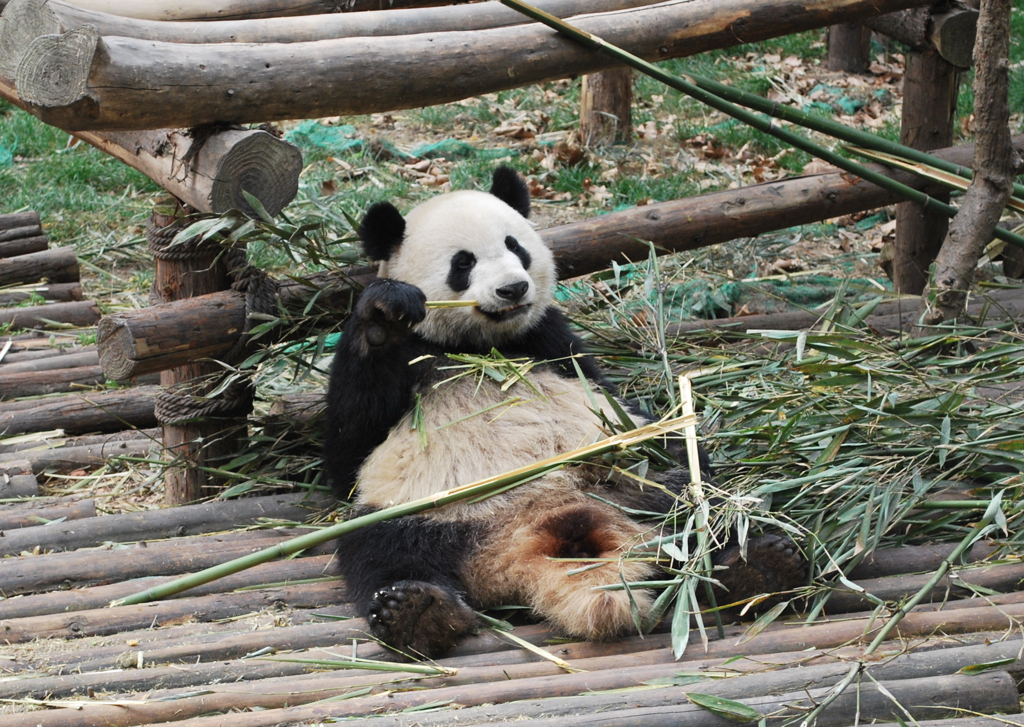

In [11]:
from PIL import Image
Image.open('/content/open-images-v7/train/data/006ffa144038c36f.jpg')

Attached to each segmentation mask image in the fo dataset, there is a filepath attr that cites the original image.



  ---
  ---
Now, I need to figure out how to load and open one of these segmentation mask images that I can open in FiftyOne gui above.

<h1>Full image instance segmentation masks method</h1>
To generate full image instance segmentation masks with this method, you have to get a bit craftier. You can iterate through the objects in a given image, filtering for each one individually, creating a view for this (single image, single object) pair, and using the objects_to_segmentations() method.

  <a href="https://medium.com/voxel51/fiftyone-computer-vision-tips-and-tricks-january-27-2023-568549920401"> Source article</a>


In [13]:
# generate segmentation masks from fiftyone format
view = dataset.select_fields("instances")

sampleCount = 1
# print(view)
for sample in view:

  # save mask array with index instead of true values

  #if('0024ce778120b3d2' in sample.filepath):
  #image = Image.open(sample.filepath)

  #imageWidth, imageHeight = image.size
  #print("imageWidth, imageHeight", imageWidth, imageHeight)
  # this image size will be used to init the shape of the global mask
  detections = sample.instances.detections

  #print("length of detections: ", len(detections))
  if len(detections) == 1:
    # print(sample)
    for detection in detections:
      # specify pixel values for classes
      mask_targets = {1: "Panda"}
      # generate semantic segmentation mask
      foul.objects_to_segmentations(
          dataset,
          "instances",
          "segmentations",
          mask_targets=mask_targets,
      )
    sampleCount += 1
  #print("\nsample count:", sampleCount)



 100% |█████████████████| 350/350 [17.4s elapsed, 0s remaining, 31.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [17.4s elapsed, 0s remaining, 31.5 samples/s]      


 100% |█████████████████| 350/350 [13.2s elapsed, 0s remaining, 20.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.2s elapsed, 0s remaining, 20.0 samples/s]      


 100% |█████████████████| 350/350 [15.6s elapsed, 0s remaining, 22.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.6s elapsed, 0s remaining, 22.7 samples/s]      


 100% |█████████████████| 350/350 [15.4s elapsed, 0s remaining, 19.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.4s elapsed, 0s remaining, 19.5 samples/s]      


 100% |█████████████████| 350/350 [13.7s elapsed, 0s remaining, 30.8 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.7s elapsed, 0s remaining, 30.8 samples/s]      


 100% |█████████████████| 350/350 [15.9s elapsed, 0s remaining, 18.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.9s elapsed, 0s remaining, 18.3 samples/s]      


 100% |█████████████████| 350/350 [12.7s elapsed, 0s remaining, 28.1 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.7s elapsed, 0s remaining, 28.1 samples/s]      


 100% |█████████████████| 350/350 [16.4s elapsed, 0s remaining, 21.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.4s elapsed, 0s remaining, 21.5 samples/s]      


 100% |█████████████████| 350/350 [12.0s elapsed, 0s remaining, 20.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.0s elapsed, 0s remaining, 20.5 samples/s]      


 100% |█████████████████| 350/350 [16.7s elapsed, 0s remaining, 28.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.7s elapsed, 0s remaining, 28.3 samples/s]      


 100% |█████████████████| 350/350 [13.0s elapsed, 0s remaining, 20.0 samples/s]       


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.0s elapsed, 0s remaining, 20.0 samples/s]       


 100% |█████████████████| 350/350 [15.0s elapsed, 0s remaining, 32.1 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.0s elapsed, 0s remaining, 32.1 samples/s]      


 100% |█████████████████| 350/350 [14.9s elapsed, 0s remaining, 18.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.9s elapsed, 0s remaining, 18.9 samples/s]      


 100% |█████████████████| 350/350 [14.4s elapsed, 0s remaining, 30.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.4s elapsed, 0s remaining, 30.4 samples/s]      


 100% |█████████████████| 350/350 [15.6s elapsed, 0s remaining, 20.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.6s elapsed, 0s remaining, 20.2 samples/s]      


 100% |█████████████████| 350/350 [12.4s elapsed, 0s remaining, 32.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.4s elapsed, 0s remaining, 32.3 samples/s]      


 100% |█████████████████| 350/350 [17.1s elapsed, 0s remaining, 20.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [17.1s elapsed, 0s remaining, 20.9 samples/s]      


 100% |█████████████████| 350/350 [12.1s elapsed, 0s remaining, 20.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.1s elapsed, 0s remaining, 20.3 samples/s]      


 100% |█████████████████| 350/350 [16.2s elapsed, 0s remaining, 32.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.2s elapsed, 0s remaining, 32.7 samples/s]      


 100% |█████████████████| 350/350 [13.2s elapsed, 0s remaining, 20.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.2s elapsed, 0s remaining, 20.4 samples/s]      


 100% |█████████████████| 350/350 [15.5s elapsed, 0s remaining, 32.1 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.5s elapsed, 0s remaining, 32.1 samples/s]      


 100% |█████████████████| 350/350 [14.4s elapsed, 0s remaining, 19.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.4s elapsed, 0s remaining, 19.5 samples/s]      


 100% |█████████████████| 350/350 [14.3s elapsed, 0s remaining, 32.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.3s elapsed, 0s remaining, 32.2 samples/s]      


 100% |█████████████████| 350/350 [15.8s elapsed, 0s remaining, 20.1 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.8s elapsed, 0s remaining, 20.1 samples/s]      


 100% |█████████████████| 350/350 [13.0s elapsed, 0s remaining, 31.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.0s elapsed, 0s remaining, 31.3 samples/s]      


 100% |█████████████████| 350/350 [16.7s elapsed, 0s remaining, 19.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.7s elapsed, 0s remaining, 19.9 samples/s]      


 100% |█████████████████| 350/350 [12.5s elapsed, 0s remaining, 20.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.5s elapsed, 0s remaining, 20.3 samples/s]      


 100% |█████████████████| 350/350 [16.7s elapsed, 0s remaining, 32.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.7s elapsed, 0s remaining, 32.2 samples/s]      


 100% |█████████████████| 350/350 [13.1s elapsed, 0s remaining, 20.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.1s elapsed, 0s remaining, 20.2 samples/s]      


 100% |█████████████████| 350/350 [15.1s elapsed, 0s remaining, 32.1 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.1s elapsed, 0s remaining, 32.1 samples/s]      


 100% |█████████████████| 350/350 [14.7s elapsed, 0s remaining, 20.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.7s elapsed, 0s remaining, 20.7 samples/s]      


 100% |█████████████████| 350/350 [13.9s elapsed, 0s remaining, 32.1 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.9s elapsed, 0s remaining, 32.1 samples/s]      


 100% |█████████████████| 350/350 [15.5s elapsed, 0s remaining, 19.8 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.5s elapsed, 0s remaining, 19.8 samples/s]      


 100% |█████████████████| 350/350 [12.6s elapsed, 0s remaining, 32.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.6s elapsed, 0s remaining, 32.6 samples/s]      


 100% |█████████████████| 350/350 [16.8s elapsed, 0s remaining, 20.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.8s elapsed, 0s remaining, 20.9 samples/s]      


 100% |█████████████████| 350/350 [11.8s elapsed, 0s remaining, 20.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [11.8s elapsed, 0s remaining, 20.9 samples/s]      


 100% |█████████████████| 350/350 [16.2s elapsed, 0s remaining, 32.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.2s elapsed, 0s remaining, 32.3 samples/s]      


 100% |█████████████████| 350/350 [13.1s elapsed, 0s remaining, 17.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.1s elapsed, 0s remaining, 17.0 samples/s]      


 100% |█████████████████| 350/350 [15.6s elapsed, 0s remaining, 32.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.6s elapsed, 0s remaining, 32.7 samples/s]      


 100% |█████████████████| 350/350 [13.8s elapsed, 0s remaining, 20.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.8s elapsed, 0s remaining, 20.3 samples/s]      


 100% |█████████████████| 350/350 [14.3s elapsed, 0s remaining, 32.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.3s elapsed, 0s remaining, 32.7 samples/s]      


 100% |█████████████████| 350/350 [15.3s elapsed, 0s remaining, 19.8 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.3s elapsed, 0s remaining, 19.8 samples/s]      


 100% |█████████████████| 350/350 [13.4s elapsed, 0s remaining, 31.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.4s elapsed, 0s remaining, 31.6 samples/s]      


 100% |█████████████████| 350/350 [16.5s elapsed, 0s remaining, 19.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.5s elapsed, 0s remaining, 19.9 samples/s]      


 100% |█████████████████| 350/350 [12.3s elapsed, 0s remaining, 20.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.3s elapsed, 0s remaining, 20.6 samples/s]      


 100% |█████████████████| 350/350 [16.8s elapsed, 0s remaining, 33.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.8s elapsed, 0s remaining, 33.0 samples/s]      


 100% |█████████████████| 350/350 [13.0s elapsed, 0s remaining, 20.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.0s elapsed, 0s remaining, 20.5 samples/s]      


 100% |█████████████████| 350/350 [15.3s elapsed, 0s remaining, 33.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.3s elapsed, 0s remaining, 33.2 samples/s]      


 100% |█████████████████| 350/350 [14.5s elapsed, 0s remaining, 19.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.5s elapsed, 0s remaining, 19.5 samples/s]      


 100% |█████████████████| 350/350 [14.1s elapsed, 0s remaining, 31.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.1s elapsed, 0s remaining, 31.6 samples/s]      


 100% |█████████████████| 350/350 [15.5s elapsed, 0s remaining, 18.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.5s elapsed, 0s remaining, 18.9 samples/s]      


 100% |█████████████████| 350/350 [13.2s elapsed, 0s remaining, 22.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.2s elapsed, 0s remaining, 22.0 samples/s]      


 100% |█████████████████| 350/350 [16.8s elapsed, 0s remaining, 21.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.8s elapsed, 0s remaining, 21.0 samples/s]      


 100% |█████████████████| 350/350 [12.1s elapsed, 0s remaining, 19.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.1s elapsed, 0s remaining, 19.7 samples/s]      


 100% |█████████████████| 350/350 [16.6s elapsed, 0s remaining, 23.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.6s elapsed, 0s remaining, 23.7 samples/s]      


 100% |█████████████████| 350/350 [13.1s elapsed, 0s remaining, 20.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.1s elapsed, 0s remaining, 20.2 samples/s]      


 100% |█████████████████| 350/350 [14.9s elapsed, 0s remaining, 32.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.9s elapsed, 0s remaining, 32.7 samples/s]      


 100% |█████████████████| 350/350 [13.7s elapsed, 0s remaining, 20.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.7s elapsed, 0s remaining, 20.9 samples/s]      


 100% |█████████████████| 350/350 [14.7s elapsed, 0s remaining, 27.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.7s elapsed, 0s remaining, 27.5 samples/s]      


 100% |█████████████████| 350/350 [15.0s elapsed, 0s remaining, 19.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.0s elapsed, 0s remaining, 19.9 samples/s]      


 100% |█████████████████| 350/350 [13.3s elapsed, 0s remaining, 32.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.3s elapsed, 0s remaining, 32.5 samples/s]      


 100% |█████████████████| 350/350 [16.7s elapsed, 0s remaining, 17.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.7s elapsed, 0s remaining, 17.0 samples/s]      


 100% |█████████████████| 350/350 [12.1s elapsed, 0s remaining, 25.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.1s elapsed, 0s remaining, 25.3 samples/s]      


 100% |█████████████████| 350/350 [16.5s elapsed, 0s remaining, 28.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.5s elapsed, 0s remaining, 28.5 samples/s]      


 100% |█████████████████| 350/350 [12.4s elapsed, 0s remaining, 20.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.4s elapsed, 0s remaining, 20.5 samples/s]      


 100% |█████████████████| 350/350 [15.9s elapsed, 0s remaining, 23.8 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.9s elapsed, 0s remaining, 23.8 samples/s]      


 100% |█████████████████| 350/350 [13.8s elapsed, 0s remaining, 20.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.8s elapsed, 0s remaining, 20.3 samples/s]      


 100% |█████████████████| 350/350 [14.7s elapsed, 0s remaining, 31.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.7s elapsed, 0s remaining, 31.7 samples/s]      


 100% |█████████████████| 350/350 [14.9s elapsed, 0s remaining, 19.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.9s elapsed, 0s remaining, 19.9 samples/s]      


 100% |█████████████████| 350/350 [13.6s elapsed, 0s remaining, 29.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.6s elapsed, 0s remaining, 29.2 samples/s]      


 100% |█████████████████| 350/350 [16.0s elapsed, 0s remaining, 20.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.0s elapsed, 0s remaining, 20.6 samples/s]      


 100% |█████████████████| 350/350 [12.3s elapsed, 0s remaining, 31.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.3s elapsed, 0s remaining, 31.4 samples/s]      


 100% |█████████████████| 350/350 [17.2s elapsed, 0s remaining, 21.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [17.2s elapsed, 0s remaining, 21.0 samples/s]      


 100% |█████████████████| 350/350 [12.0s elapsed, 0s remaining, 17.8 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.0s elapsed, 0s remaining, 17.8 samples/s]      


 100% |█████████████████| 350/350 [16.0s elapsed, 0s remaining, 32.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.0s elapsed, 0s remaining, 32.3 samples/s]      


 100% |█████████████████| 350/350 [13.3s elapsed, 0s remaining, 19.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.3s elapsed, 0s remaining, 19.5 samples/s]      


 100% |█████████████████| 350/350 [15.3s elapsed, 0s remaining, 23.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.3s elapsed, 0s remaining, 23.7 samples/s]      


 100% |█████████████████| 350/350 [14.1s elapsed, 0s remaining, 20.1 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.1s elapsed, 0s remaining, 20.1 samples/s]      


 100% |█████████████████| 350/350 [14.1s elapsed, 0s remaining, 32.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.1s elapsed, 0s remaining, 32.2 samples/s]      


 100% |█████████████████| 350/350 [15.1s elapsed, 0s remaining, 19.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.1s elapsed, 0s remaining, 19.5 samples/s]      


 100% |█████████████████| 350/350 [13.4s elapsed, 0s remaining, 25.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.4s elapsed, 0s remaining, 25.9 samples/s]      


 100% |█████████████████| 350/350 [15.9s elapsed, 0s remaining, 19.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.9s elapsed, 0s remaining, 19.4 samples/s]      


 100% |█████████████████| 350/350 [12.0s elapsed, 0s remaining, 31.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.0s elapsed, 0s remaining, 31.4 samples/s]      


 100% |█████████████████| 350/350 [17.3s elapsed, 0s remaining, 22.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [17.3s elapsed, 0s remaining, 22.2 samples/s]      


 100% |█████████████████| 350/350 [12.0s elapsed, 0s remaining, 19.8 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.0s elapsed, 0s remaining, 19.8 samples/s]      


 100% |█████████████████| 350/350 [16.0s elapsed, 0s remaining, 31.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.0s elapsed, 0s remaining, 31.9 samples/s]      


 100% |█████████████████| 350/350 [12.8s elapsed, 0s remaining, 19.8 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.8s elapsed, 0s remaining, 19.8 samples/s]      


 100% |█████████████████| 350/350 [15.6s elapsed, 0s remaining, 25.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.6s elapsed, 0s remaining, 25.9 samples/s]      


 100% |█████████████████| 350/350 [13.7s elapsed, 0s remaining, 20.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.7s elapsed, 0s remaining, 20.4 samples/s]      


 100% |█████████████████| 350/350 [14.5s elapsed, 0s remaining, 31.8 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.5s elapsed, 0s remaining, 31.8 samples/s]      


 100% |█████████████████| 350/350 [14.4s elapsed, 0s remaining, 21.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.4s elapsed, 0s remaining, 21.2 samples/s]      


 100% |█████████████████| 350/350 [14.1s elapsed, 0s remaining, 31.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.1s elapsed, 0s remaining, 31.0 samples/s]      


 100% |█████████████████| 350/350 [16.0s elapsed, 0s remaining, 19.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.0s elapsed, 0s remaining, 19.9 samples/s]      


 100% |█████████████████| 350/350 [12.7s elapsed, 0s remaining, 32.1 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.7s elapsed, 0s remaining, 32.1 samples/s]      


 100% |█████████████████| 350/350 [17.4s elapsed, 0s remaining, 20.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [17.4s elapsed, 0s remaining, 20.4 samples/s]      


 100% |█████████████████| 350/350 [12.1s elapsed, 0s remaining, 19.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.1s elapsed, 0s remaining, 19.3 samples/s]      


 100% |█████████████████| 350/350 [16.3s elapsed, 0s remaining, 32.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.3s elapsed, 0s remaining, 32.0 samples/s]      


 100% |█████████████████| 350/350 [13.1s elapsed, 0s remaining, 20.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.1s elapsed, 0s remaining, 20.3 samples/s]      


 100% |█████████████████| 350/350 [15.3s elapsed, 0s remaining, 32.1 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.3s elapsed, 0s remaining, 32.1 samples/s]      


 100% |█████████████████| 350/350 [13.9s elapsed, 0s remaining, 20.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.9s elapsed, 0s remaining, 20.4 samples/s]      


 100% |█████████████████| 350/350 [14.4s elapsed, 0s remaining, 32.1 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.4s elapsed, 0s remaining, 32.1 samples/s]      


 100% |█████████████████| 350/350 [15.4s elapsed, 0s remaining, 13.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.4s elapsed, 0s remaining, 13.6 samples/s]      


 100% |█████████████████| 350/350 [13.0s elapsed, 0s remaining, 32.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.0s elapsed, 0s remaining, 32.5 samples/s]      


 100% |█████████████████| 350/350 [15.9s elapsed, 0s remaining, 20.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.9s elapsed, 0s remaining, 20.5 samples/s]      


 100% |█████████████████| 350/350 [12.2s elapsed, 0s remaining, 31.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.2s elapsed, 0s remaining, 31.5 samples/s]      


 100% |█████████████████| 350/350 [17.2s elapsed, 0s remaining, 23.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [17.2s elapsed, 0s remaining, 23.3 samples/s]      


 100% |█████████████████| 350/350 [12.2s elapsed, 0s remaining, 20.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.2s elapsed, 0s remaining, 20.3 samples/s]      


 100% |█████████████████| 350/350 [16.0s elapsed, 0s remaining, 31.1 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.0s elapsed, 0s remaining, 31.1 samples/s]      


 100% |█████████████████| 350/350 [13.4s elapsed, 0s remaining, 19.1 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.4s elapsed, 0s remaining, 19.1 samples/s]      


 100% |█████████████████| 350/350 [14.9s elapsed, 0s remaining, 32.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.9s elapsed, 0s remaining, 32.7 samples/s]      


 100% |█████████████████| 350/350 [14.2s elapsed, 0s remaining, 21.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.2s elapsed, 0s remaining, 21.0 samples/s]      


 100% |█████████████████| 350/350 [13.9s elapsed, 0s remaining, 32.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.9s elapsed, 0s remaining, 32.0 samples/s]      


 100% |█████████████████| 350/350 [15.7s elapsed, 0s remaining, 20.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.7s elapsed, 0s remaining, 20.0 samples/s]      


 100% |█████████████████| 350/350 [12.9s elapsed, 0s remaining, 32.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.9s elapsed, 0s remaining, 32.4 samples/s]      


 100% |█████████████████| 350/350 [16.4s elapsed, 0s remaining, 20.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.4s elapsed, 0s remaining, 20.5 samples/s]      


 100% |█████████████████| 350/350 [11.8s elapsed, 0s remaining, 22.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [11.8s elapsed, 0s remaining, 22.7 samples/s]      


 100% |█████████████████| 350/350 [16.9s elapsed, 0s remaining, 32.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.9s elapsed, 0s remaining, 32.0 samples/s]      


 100% |█████████████████| 350/350 [12.9s elapsed, 0s remaining, 19.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.9s elapsed, 0s remaining, 19.6 samples/s]      


 100% |█████████████████| 350/350 [15.4s elapsed, 0s remaining, 33.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.4s elapsed, 0s remaining, 33.0 samples/s]      


 100% |█████████████████| 350/350 [14.1s elapsed, 0s remaining, 16.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.1s elapsed, 0s remaining, 16.2 samples/s]      


 100% |█████████████████| 350/350 [14.5s elapsed, 0s remaining, 32.1 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.5s elapsed, 0s remaining, 32.1 samples/s]      


 100% |█████████████████| 350/350 [15.0s elapsed, 0s remaining, 19.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.0s elapsed, 0s remaining, 19.7 samples/s]      


 100% |█████████████████| 350/350 [13.4s elapsed, 0s remaining, 32.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.4s elapsed, 0s remaining, 32.0 samples/s]      


 100% |█████████████████| 350/350 [16.0s elapsed, 0s remaining, 20.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.0s elapsed, 0s remaining, 20.0 samples/s]      


 100% |█████████████████| 350/350 [12.3s elapsed, 0s remaining, 31.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.3s elapsed, 0s remaining, 31.9 samples/s]      


 100% |█████████████████| 350/350 [16.4s elapsed, 0s remaining, 20.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.4s elapsed, 0s remaining, 20.6 samples/s]      


 100% |█████████████████| 350/350 [12.0s elapsed, 0s remaining, 20.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.0s elapsed, 0s remaining, 20.5 samples/s]      


 100% |█████████████████| 350/350 [16.9s elapsed, 0s remaining, 32.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.9s elapsed, 0s remaining, 32.2 samples/s]      


 100% |█████████████████| 350/350 [12.8s elapsed, 0s remaining, 21.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.8s elapsed, 0s remaining, 21.0 samples/s]      


 100% |█████████████████| 350/350 [15.5s elapsed, 0s remaining, 30.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.5s elapsed, 0s remaining, 30.9 samples/s]      


 100% |█████████████████| 350/350 [14.5s elapsed, 0s remaining, 20.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.5s elapsed, 0s remaining, 20.0 samples/s]      


 100% |█████████████████| 350/350 [13.9s elapsed, 0s remaining, 32.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.9s elapsed, 0s remaining, 32.7 samples/s]      


 100% |█████████████████| 350/350 [15.1s elapsed, 0s remaining, 20.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.1s elapsed, 0s remaining, 20.2 samples/s]      


 100% |█████████████████| 350/350 [13.3s elapsed, 0s remaining, 31.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.3s elapsed, 0s remaining, 31.2 samples/s]      


 100% |█████████████████| 350/350 [17.0s elapsed, 0s remaining, 20.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [17.0s elapsed, 0s remaining, 20.2 samples/s]      


 100% |█████████████████| 350/350 [12.4s elapsed, 0s remaining, 21.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.4s elapsed, 0s remaining, 21.6 samples/s]      


 100% |█████████████████| 350/350 [16.8s elapsed, 0s remaining, 22.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.8s elapsed, 0s remaining, 22.9 samples/s]      


 100% |█████████████████| 350/350 [13.0s elapsed, 0s remaining, 19.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.0s elapsed, 0s remaining, 19.4 samples/s]      


 100% |█████████████████| 350/350 [16.1s elapsed, 0s remaining, 29.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.1s elapsed, 0s remaining, 29.7 samples/s]      


 100% |█████████████████| 350/350 [13.8s elapsed, 0s remaining, 20.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.8s elapsed, 0s remaining, 20.5 samples/s]      


 100% |█████████████████| 350/350 [15.2s elapsed, 0s remaining, 31.1 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.2s elapsed, 0s remaining, 31.1 samples/s]      


 100% |█████████████████| 350/350 [17.9s elapsed, 0s remaining, 18.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [17.9s elapsed, 0s remaining, 18.9 samples/s]      


 100% |█████████████████| 350/350 [16.3s elapsed, 0s remaining, 30.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.3s elapsed, 0s remaining, 30.3 samples/s]      


 100% |█████████████████| 350/350 [13.8s elapsed, 0s remaining, 20.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.8s elapsed, 0s remaining, 20.9 samples/s]      


 100% |█████████████████| 350/350 [14.9s elapsed, 0s remaining, 31.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.9s elapsed, 0s remaining, 31.5 samples/s]      


 100% |█████████████████| 350/350 [15.1s elapsed, 0s remaining, 15.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.1s elapsed, 0s remaining, 15.6 samples/s]      


 100% |█████████████████| 350/350 [14.1s elapsed, 0s remaining, 31.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.1s elapsed, 0s remaining, 31.9 samples/s]      


 100% |█████████████████| 350/350 [15.9s elapsed, 0s remaining, 19.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.9s elapsed, 0s remaining, 19.6 samples/s]      


 100% |█████████████████| 350/350 [12.8s elapsed, 0s remaining, 31.8 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.8s elapsed, 0s remaining, 31.8 samples/s]      


 100% |█████████████████| 350/350 [17.0s elapsed, 0s remaining, 20.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [17.0s elapsed, 0s remaining, 20.3 samples/s]      


 100% |█████████████████| 350/350 [12.4s elapsed, 0s remaining, 22.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.4s elapsed, 0s remaining, 22.0 samples/s]      


 100% |█████████████████| 350/350 [16.6s elapsed, 0s remaining, 28.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.6s elapsed, 0s remaining, 28.0 samples/s]      


 100% |█████████████████| 350/350 [13.1s elapsed, 0s remaining, 14.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.1s elapsed, 0s remaining, 14.4 samples/s]      


 100% |█████████████████| 350/350 [16.1s elapsed, 0s remaining, 31.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.1s elapsed, 0s remaining, 31.0 samples/s]      


 100% |█████████████████| 350/350 [13.7s elapsed, 0s remaining, 20.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.7s elapsed, 0s remaining, 20.2 samples/s]      


 100% |█████████████████| 350/350 [15.4s elapsed, 0s remaining, 25.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.4s elapsed, 0s remaining, 25.4 samples/s]      


 100% |█████████████████| 350/350 [14.5s elapsed, 0s remaining, 20.1 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.5s elapsed, 0s remaining, 20.1 samples/s]      


 100% |█████████████████| 350/350 [14.3s elapsed, 0s remaining, 31.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.3s elapsed, 0s remaining, 31.3 samples/s]      


 100% |█████████████████| 350/350 [15.7s elapsed, 0s remaining, 13.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.7s elapsed, 0s remaining, 13.9 samples/s]      


 100% |█████████████████| 350/350 [13.3s elapsed, 0s remaining, 31.1 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.3s elapsed, 0s remaining, 31.1 samples/s]      


 100% |█████████████████| 350/350 [16.3s elapsed, 0s remaining, 19.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.3s elapsed, 0s remaining, 19.4 samples/s]      


 100% |█████████████████| 350/350 [12.5s elapsed, 0s remaining, 31.8 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.5s elapsed, 0s remaining, 31.8 samples/s]      


 100% |█████████████████| 350/350 [17.4s elapsed, 0s remaining, 22.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [17.4s elapsed, 0s remaining, 22.2 samples/s]      


 100% |█████████████████| 350/350 [16.1s elapsed, 0s remaining, 19.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.1s elapsed, 0s remaining, 19.0 samples/s]      


 100% |█████████████████| 350/350 [18.1s elapsed, 0s remaining, 23.8 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [18.1s elapsed, 0s remaining, 23.8 samples/s]      


 100% |█████████████████| 350/350 [12.8s elapsed, 0s remaining, 19.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.8s elapsed, 0s remaining, 19.5 samples/s]      


 100% |█████████████████| 350/350 [16.1s elapsed, 0s remaining, 30.8 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.1s elapsed, 0s remaining, 30.8 samples/s]      


 100% |█████████████████| 350/350 [13.9s elapsed, 0s remaining, 15.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.9s elapsed, 0s remaining, 15.9 samples/s]      


 100% |█████████████████| 350/350 [14.9s elapsed, 0s remaining, 31.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.9s elapsed, 0s remaining, 31.7 samples/s]      


 100% |█████████████████| 350/350 [14.9s elapsed, 0s remaining, 20.1 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.9s elapsed, 0s remaining, 20.1 samples/s]      


 100% |█████████████████| 350/350 [14.1s elapsed, 0s remaining, 31.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.1s elapsed, 0s remaining, 31.5 samples/s]      


 100% |█████████████████| 350/350 [16.2s elapsed, 0s remaining, 19.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.2s elapsed, 0s remaining, 19.2 samples/s]      


 100% |█████████████████| 350/350 [12.8s elapsed, 0s remaining, 32.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.8s elapsed, 0s remaining, 32.0 samples/s]      


 100% |█████████████████| 350/350 [16.8s elapsed, 0s remaining, 20.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.8s elapsed, 0s remaining, 20.6 samples/s]      


 100% |█████████████████| 350/350 [12.6s elapsed, 0s remaining, 17.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.6s elapsed, 0s remaining, 17.0 samples/s]      


 100% |█████████████████| 350/350 [16.8s elapsed, 0s remaining, 30.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.8s elapsed, 0s remaining, 30.4 samples/s]      


 100% |█████████████████| 350/350 [13.0s elapsed, 0s remaining, 19.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.0s elapsed, 0s remaining, 19.5 samples/s]      


 100% |█████████████████| 350/350 [16.4s elapsed, 0s remaining, 31.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.4s elapsed, 0s remaining, 31.2 samples/s]      


 100% |█████████████████| 350/350 [14.6s elapsed, 0s remaining, 20.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.6s elapsed, 0s remaining, 20.3 samples/s]      


 100% |█████████████████| 350/350 [14.5s elapsed, 0s remaining, 31.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.5s elapsed, 0s remaining, 31.2 samples/s]      


 100% |█████████████████| 350/350 [15.6s elapsed, 0s remaining, 20.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.6s elapsed, 0s remaining, 20.4 samples/s]      


 100% |█████████████████| 350/350 [14.1s elapsed, 0s remaining, 30.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.1s elapsed, 0s remaining, 30.5 samples/s]      


 100% |█████████████████| 350/350 [16.8s elapsed, 0s remaining, 20.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.8s elapsed, 0s remaining, 20.4 samples/s]      


 100% |█████████████████| 350/350 [12.7s elapsed, 0s remaining, 20.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.7s elapsed, 0s remaining, 20.5 samples/s]      


 100% |█████████████████| 350/350 [17.0s elapsed, 0s remaining, 27.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [17.0s elapsed, 0s remaining, 27.0 samples/s]      


 100% |█████████████████| 350/350 [14.0s elapsed, 0s remaining, 20.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.0s elapsed, 0s remaining, 20.4 samples/s]      


 100% |█████████████████| 350/350 [18.6s elapsed, 0s remaining, 20.8 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [18.6s elapsed, 0s remaining, 20.8 samples/s]      


 100% |█████████████████| 350/350 [13.2s elapsed, 0s remaining, 31.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.2s elapsed, 0s remaining, 31.3 samples/s]      


 100% |█████████████████| 350/350 [16.4s elapsed, 0s remaining, 19.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.4s elapsed, 0s remaining, 19.7 samples/s]      


 100% |█████████████████| 350/350 [12.7s elapsed, 0s remaining, 28.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.7s elapsed, 0s remaining, 28.2 samples/s]      


 100% |█████████████████| 350/350 [17.2s elapsed, 0s remaining, 26.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [17.2s elapsed, 0s remaining, 26.9 samples/s]      


 100% |█████████████████| 350/350 [12.9s elapsed, 0s remaining, 20.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.9s elapsed, 0s remaining, 20.3 samples/s]      


 100% |█████████████████| 350/350 [16.1s elapsed, 0s remaining, 31.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.1s elapsed, 0s remaining, 31.5 samples/s]      


 100% |█████████████████| 350/350 [13.9s elapsed, 0s remaining, 19.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.9s elapsed, 0s remaining, 19.7 samples/s]      


 100% |█████████████████| 350/350 [14.9s elapsed, 0s remaining, 31.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.9s elapsed, 0s remaining, 31.5 samples/s]      


 100% |█████████████████| 350/350 [15.3s elapsed, 0s remaining, 15.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.3s elapsed, 0s remaining, 15.4 samples/s]      


 100% |█████████████████| 350/350 [13.5s elapsed, 0s remaining, 31.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.5s elapsed, 0s remaining, 31.7 samples/s]      


 100% |█████████████████| 350/350 [16.4s elapsed, 0s remaining, 19.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.4s elapsed, 0s remaining, 19.7 samples/s]      


 100% |█████████████████| 350/350 [12.6s elapsed, 0s remaining, 30.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.6s elapsed, 0s remaining, 30.3 samples/s]      


 100% |█████████████████| 350/350 [17.0s elapsed, 0s remaining, 20.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [17.0s elapsed, 0s remaining, 20.9 samples/s]      


 100% |█████████████████| 350/350 [12.1s elapsed, 0s remaining, 20.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.1s elapsed, 0s remaining, 20.4 samples/s]      


 100% |█████████████████| 350/350 [16.7s elapsed, 0s remaining, 30.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.7s elapsed, 0s remaining, 30.0 samples/s]      


 100% |█████████████████| 350/350 [13.2s elapsed, 0s remaining, 17.1 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.2s elapsed, 0s remaining, 17.1 samples/s]      


 100% |█████████████████| 350/350 [15.9s elapsed, 0s remaining, 31.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.9s elapsed, 0s remaining, 31.7 samples/s]      


 100% |█████████████████| 350/350 [13.7s elapsed, 0s remaining, 20.1 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.7s elapsed, 0s remaining, 20.1 samples/s]      


 100% |█████████████████| 350/350 [15.2s elapsed, 0s remaining, 24.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.2s elapsed, 0s remaining, 24.2 samples/s]      


 100% |█████████████████| 350/350 [14.9s elapsed, 0s remaining, 20.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.9s elapsed, 0s remaining, 20.4 samples/s]      


 100% |█████████████████| 350/350 [13.9s elapsed, 0s remaining, 31.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.9s elapsed, 0s remaining, 31.9 samples/s]      


 100% |█████████████████| 350/350 [17.1s elapsed, 0s remaining, 15.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [17.1s elapsed, 0s remaining, 15.2 samples/s]      


 100% |█████████████████| 350/350 [16.3s elapsed, 0s remaining, 31.8 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.3s elapsed, 0s remaining, 31.8 samples/s]      


 100% |█████████████████| 350/350 [14.2s elapsed, 0s remaining, 19.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.2s elapsed, 0s remaining, 19.9 samples/s]      


 100% |█████████████████| 350/350 [14.8s elapsed, 0s remaining, 26.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.8s elapsed, 0s remaining, 26.3 samples/s]      


 100% |█████████████████| 350/350 [15.2s elapsed, 0s remaining, 19.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.2s elapsed, 0s remaining, 19.7 samples/s]      


 100% |█████████████████| 350/350 [14.3s elapsed, 0s remaining, 30.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.3s elapsed, 0s remaining, 30.3 samples/s]      


 100% |█████████████████| 350/350 [16.6s elapsed, 0s remaining, 18.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.6s elapsed, 0s remaining, 18.0 samples/s]      


 100% |█████████████████| 350/350 [13.2s elapsed, 0s remaining, 31.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.2s elapsed, 0s remaining, 31.5 samples/s]      


 100% |█████████████████| 350/350 [17.2s elapsed, 0s remaining, 25.1 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [17.2s elapsed, 0s remaining, 25.1 samples/s]      


 100% |█████████████████| 350/350 [13.1s elapsed, 0s remaining, 19.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.1s elapsed, 0s remaining, 19.9 samples/s]      


 100% |█████████████████| 350/350 [16.3s elapsed, 0s remaining, 31.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.3s elapsed, 0s remaining, 31.2 samples/s]      


 100% |█████████████████| 350/350 [14.0s elapsed, 0s remaining, 19.8 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.0s elapsed, 0s remaining, 19.8 samples/s]      


 100% |█████████████████| 350/350 [15.1s elapsed, 0s remaining, 30.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.1s elapsed, 0s remaining, 30.3 samples/s]      


 100% |█████████████████| 350/350 [15.4s elapsed, 0s remaining, 19.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.4s elapsed, 0s remaining, 19.6 samples/s]      


 100% |█████████████████| 350/350 [14.0s elapsed, 0s remaining, 31.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.0s elapsed, 0s remaining, 31.4 samples/s]      


 100% |█████████████████| 350/350 [16.1s elapsed, 0s remaining, 19.8 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.1s elapsed, 0s remaining, 19.8 samples/s]      


 100% |█████████████████| 350/350 [13.2s elapsed, 0s remaining, 23.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.2s elapsed, 0s remaining, 23.7 samples/s]      


 100% |█████████████████| 350/350 [17.4s elapsed, 0s remaining, 20.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [17.4s elapsed, 0s remaining, 20.3 samples/s]      


 100% |█████████████████| 350/350 [12.7s elapsed, 0s remaining, 19.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.7s elapsed, 0s remaining, 19.0 samples/s]      


 100% |█████████████████| 350/350 [16.8s elapsed, 0s remaining, 30.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.8s elapsed, 0s remaining, 30.0 samples/s]      


 100% |█████████████████| 350/350 [13.0s elapsed, 0s remaining, 19.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.0s elapsed, 0s remaining, 19.3 samples/s]      


 100% |█████████████████| 350/350 [16.1s elapsed, 0s remaining, 31.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.1s elapsed, 0s remaining, 31.6 samples/s]      


 100% |█████████████████| 350/350 [16.6s elapsed, 0s remaining, 18.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.6s elapsed, 0s remaining, 18.6 samples/s]      


 100% |█████████████████| 350/350 [18.3s elapsed, 0s remaining, 25.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [18.3s elapsed, 0s remaining, 25.2 samples/s]      


 100% |█████████████████| 350/350 [12.9s elapsed, 0s remaining, 18.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.9s elapsed, 0s remaining, 18.6 samples/s]      


 100% |█████████████████| 350/350 [16.5s elapsed, 0s remaining, 31.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.5s elapsed, 0s remaining, 31.5 samples/s]      


 100% |█████████████████| 350/350 [13.8s elapsed, 0s remaining, 19.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.8s elapsed, 0s remaining, 19.0 samples/s]      


 100% |█████████████████| 350/350 [15.4s elapsed, 0s remaining, 30.8 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.4s elapsed, 0s remaining, 30.8 samples/s]      


 100% |█████████████████| 350/350 [15.0s elapsed, 0s remaining, 20.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.0s elapsed, 0s remaining, 20.6 samples/s]      


 100% |█████████████████| 350/350 [14.7s elapsed, 0s remaining, 30.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.7s elapsed, 0s remaining, 30.2 samples/s]      


 100% |█████████████████| 350/350 [15.8s elapsed, 0s remaining, 19.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.8s elapsed, 0s remaining, 19.5 samples/s]      


 100% |█████████████████| 350/350 [13.7s elapsed, 0s remaining, 30.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.7s elapsed, 0s remaining, 30.4 samples/s]      


 100% |█████████████████| 350/350 [16.8s elapsed, 0s remaining, 20.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.8s elapsed, 0s remaining, 20.2 samples/s]      


 100% |█████████████████| 350/350 [12.8s elapsed, 0s remaining, 19.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.8s elapsed, 0s remaining, 19.6 samples/s]      


 100% |█████████████████| 350/350 [17.0s elapsed, 0s remaining, 27.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [17.0s elapsed, 0s remaining, 27.0 samples/s]      


 100% |█████████████████| 350/350 [12.9s elapsed, 0s remaining, 19.8 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.9s elapsed, 0s remaining, 19.8 samples/s]      


 100% |█████████████████| 350/350 [16.0s elapsed, 0s remaining, 30.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.0s elapsed, 0s remaining, 30.3 samples/s]      


 100% |█████████████████| 350/350 [14.1s elapsed, 0s remaining, 19.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.1s elapsed, 0s remaining, 19.6 samples/s]      


 100% |█████████████████| 350/350 [15.3s elapsed, 0s remaining, 31.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.3s elapsed, 0s remaining, 31.7 samples/s]      


 100% |█████████████████| 350/350 [14.6s elapsed, 0s remaining, 20.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.6s elapsed, 0s remaining, 20.2 samples/s]      


 100% |█████████████████| 350/350 [14.6s elapsed, 0s remaining, 26.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.6s elapsed, 0s remaining, 26.9 samples/s]      


 100% |█████████████████| 350/350 [15.5s elapsed, 0s remaining, 18.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.5s elapsed, 0s remaining, 18.4 samples/s]      


 100% |█████████████████| 350/350 [13.3s elapsed, 0s remaining, 31.8 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.3s elapsed, 0s remaining, 31.8 samples/s]      


 100% |█████████████████| 350/350 [16.1s elapsed, 0s remaining, 19.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.1s elapsed, 0s remaining, 19.6 samples/s]      


 100% |█████████████████| 350/350 [17.9s elapsed, 0s remaining, 17.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [17.9s elapsed, 0s remaining, 17.2 samples/s]      


 100% |█████████████████| 350/350 [18.4s elapsed, 0s remaining, 16.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [18.4s elapsed, 0s remaining, 16.2 samples/s]      


 100% |█████████████████| 350/350 [12.7s elapsed, 0s remaining, 18.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.7s elapsed, 0s remaining, 18.0 samples/s]      


 100% |█████████████████| 350/350 [16.4s elapsed, 0s remaining, 31.8 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.4s elapsed, 0s remaining, 31.8 samples/s]      


 100% |█████████████████| 350/350 [13.4s elapsed, 0s remaining, 19.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.4s elapsed, 0s remaining, 19.2 samples/s]      


 100% |█████████████████| 350/350 [15.7s elapsed, 0s remaining, 31.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.7s elapsed, 0s remaining, 31.9 samples/s]      


 100% |█████████████████| 350/350 [14.3s elapsed, 0s remaining, 20.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.3s elapsed, 0s remaining, 20.2 samples/s]      


 100% |█████████████████| 350/350 [14.5s elapsed, 0s remaining, 32.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.5s elapsed, 0s remaining, 32.2 samples/s]      


 100% |█████████████████| 350/350 [15.4s elapsed, 0s remaining, 14.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.4s elapsed, 0s remaining, 14.6 samples/s]      


 100% |█████████████████| 350/350 [13.8s elapsed, 0s remaining, 31.8 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.8s elapsed, 0s remaining, 31.8 samples/s]      


 100% |█████████████████| 350/350 [16.5s elapsed, 0s remaining, 20.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.5s elapsed, 0s remaining, 20.3 samples/s]      


 100% |█████████████████| 350/350 [12.6s elapsed, 0s remaining, 27.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.6s elapsed, 0s remaining, 27.4 samples/s]      


 100% |█████████████████| 350/350 [17.2s elapsed, 0s remaining, 30.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [17.2s elapsed, 0s remaining, 30.0 samples/s]      


 100% |█████████████████| 350/350 [12.8s elapsed, 0s remaining, 20.8 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.8s elapsed, 0s remaining, 20.8 samples/s]      


 100% |█████████████████| 350/350 [15.7s elapsed, 0s remaining, 32.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.7s elapsed, 0s remaining, 32.3 samples/s]      


 100% |█████████████████| 350/350 [14.0s elapsed, 0s remaining, 17.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.0s elapsed, 0s remaining, 17.4 samples/s]      


 100% |█████████████████| 350/350 [14.3s elapsed, 0s remaining, 32.8 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.3s elapsed, 0s remaining, 32.8 samples/s]      


 100% |█████████████████| 350/350 [14.4s elapsed, 0s remaining, 20.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.4s elapsed, 0s remaining, 20.4 samples/s]      


 100% |█████████████████| 350/350 [13.6s elapsed, 0s remaining, 32.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.6s elapsed, 0s remaining, 32.3 samples/s]      


 100% |█████████████████| 350/350 [15.2s elapsed, 0s remaining, 19.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.2s elapsed, 0s remaining, 19.6 samples/s]      


 100% |█████████████████| 350/350 [13.0s elapsed, 0s remaining, 32.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.0s elapsed, 0s remaining, 32.6 samples/s]      


 100% |█████████████████| 350/350 [16.8s elapsed, 0s remaining, 17.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.8s elapsed, 0s remaining, 17.7 samples/s]      


 100% |█████████████████| 350/350 [18.0s elapsed, 0s remaining, 20.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [18.0s elapsed, 0s remaining, 20.9 samples/s]      


 100% |█████████████████| 350/350 [16.8s elapsed, 0s remaining, 31.1 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.8s elapsed, 0s remaining, 31.1 samples/s]      


 100% |█████████████████| 350/350 [12.8s elapsed, 0s remaining, 21.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [12.8s elapsed, 0s remaining, 21.5 samples/s]      


 100% |█████████████████| 350/350 [16.0s elapsed, 0s remaining, 31.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.0s elapsed, 0s remaining, 31.2 samples/s]      


 100% |█████████████████| 350/350 [13.2s elapsed, 0s remaining, 20.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.2s elapsed, 0s remaining, 20.9 samples/s]      


 100% |█████████████████| 350/350 [15.1s elapsed, 0s remaining, 31.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.1s elapsed, 0s remaining, 31.9 samples/s]      


 100% |█████████████████| 350/350 [14.3s elapsed, 0s remaining, 15.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.3s elapsed, 0s remaining, 15.5 samples/s]      


 100% |█████████████████| 350/350 [14.3s elapsed, 0s remaining, 31.8 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [14.3s elapsed, 0s remaining, 31.8 samples/s]      


 100% |█████████████████| 350/350 [15.0s elapsed, 0s remaining, 20.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [15.0s elapsed, 0s remaining, 20.0 samples/s]      


 100% |█████████████████| 350/350 [13.7s elapsed, 0s remaining, 31.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [13.7s elapsed, 0s remaining, 31.3 samples/s]      


 100% |█████████████████| 350/350 [16.5s elapsed, 0s remaining, 20.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 350/350 [16.5s elapsed, 0s remaining, 20.6 samples/s]      


<h1>What's in the box?</h1>
Sample :{ id, media_type, filepath, tags, metadata, ground_truth: {  Detections : { Detection : id, attributes, tags, label, bounding_box, mask, confidence, index }
}
<br/><br/>
<p>
We see in each sample,
a object called Detections which holds an array called detections.

Each detection is an instance of a picture frame, with it's own set of label, bounding box coordinates and mask 2D array
</p>

In [14]:
dataset

Name:        open-images-v7-train-1000
Media type:  image
Num samples: 350
Persistent:  False
Tags:        []
Sample fields:
    id:            fiftyone.core.fields.ObjectIdField
    filepath:      fiftyone.core.fields.StringField
    tags:          fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    instances:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    segmentations: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Segmentation)

EXAMPLE setup:
Let's have a look at the dataset and how it is layed down.

The data is structured as follows
```
PennFudanPed/
  PedMasks/
    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
  PNGImages/
    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
```

Here is one example of an image in the dataset, with its corresponding instance segmentation mask

In [15]:
%%shell

cd open-images-v7/train/

mkdir frame-masks

In [ ]:
## CLEAN UP script

# %%shell
# cd /content/open-images-v7/train/frame-masks
# rm -rf *.jpg

Now we've got our segmentation masks filtered with a single instance per image, we need to save the mask as an image and open it up.

In [16]:
from torchvision.models import segmentation
from PIL import Image as im
import os

view = dataset.select_fields("segmentations")
for sample in view:
    #print(sample)
    #print("sample.filepath.shape: ", np.asarray(im.open(sample.filepath)).shape )
    #print("segmentations.mask.shape: ", sample.segmentations.mask.shape)
    # creating image object of
    # above array
    mask = im.fromarray(sample.segmentations.mask)
    
    # parse filepath for the image name
    sample_filename = os.path.split(sample.filepath)[1].split('.')[0]
    mask_output_dir = '/content/open-images-v7/train/frame-masks'
    mask_output_path = mask_output_dir + '/' + sample_filename + '.jpg'
    #print("mask_output_path  ", mask_output_path)
    mask.save(mask_output_path)

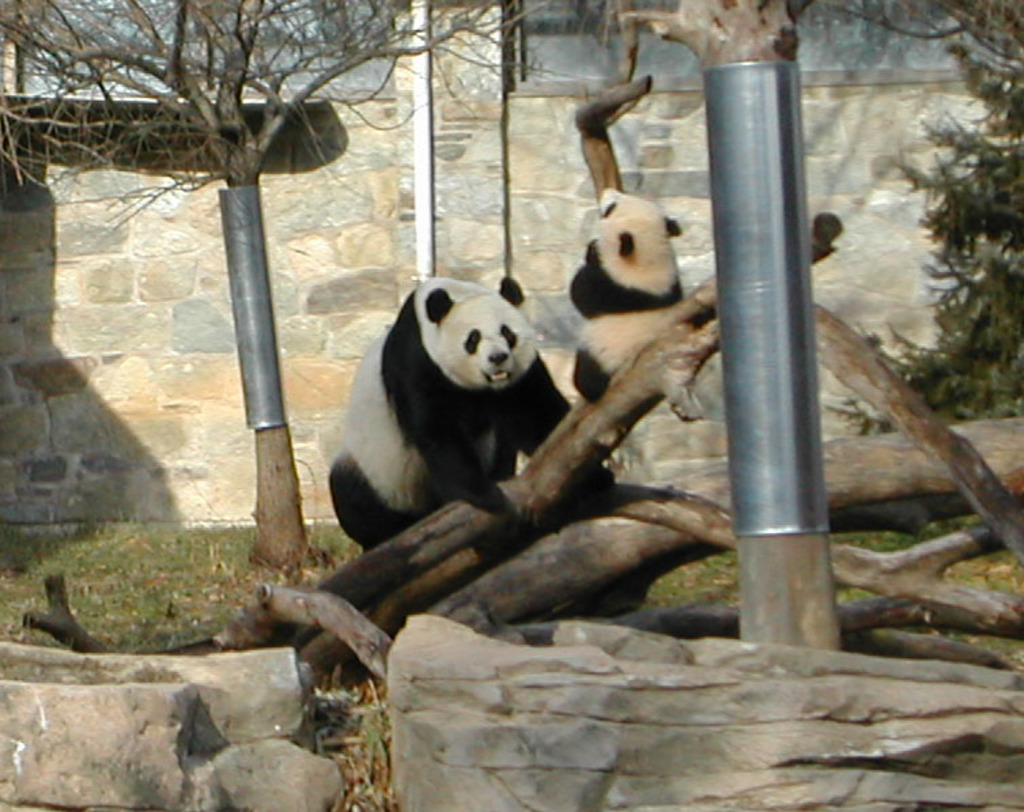

In [119]:
im.open('/content/open-images-v7/train/data/e94192640ab14c58.jpg')

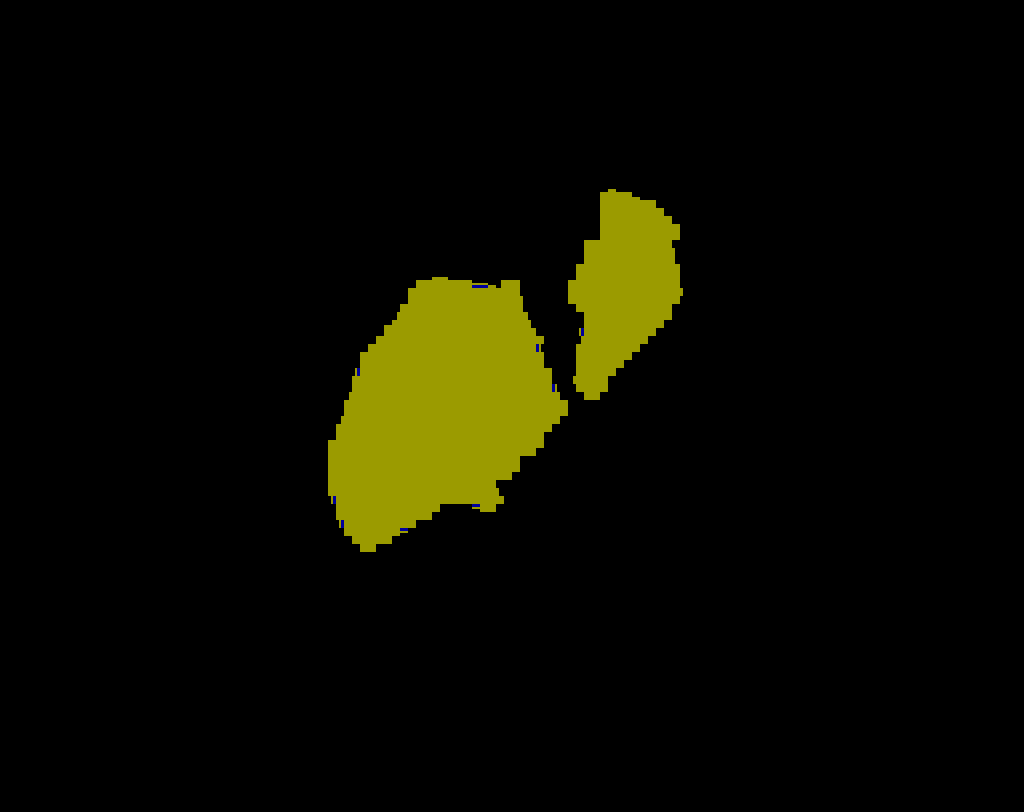

In [120]:
mask = Image.open('/content/open-images-v7/train/frame-masks/e94192640ab14c58.jpg')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. 
mask.convert('L')
#In order to make visualization easier,
# let's add a color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    155, 155, 0, # index 1 is red
    0, 0, 155, # index 2 is yellow
])
mask

So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

In [127]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PictureFramesDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "data"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "frame-masks"))))

    def __getitem__(self, idx):
        # load images ad masks

        # this may load all images and mask, even the ones
        # filtered out of the dataset
        img_path = os.path.join(self.root, "data", self.imgs[idx])
        #print(img_path)
        mask_path = os.path.join(self.root, "frame-masks", self.masks[idx])
        #print(mask_path)
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path).convert('L')

        mask = np.array(mask)
        #print('mask: ', mask)
        # instances are encoded as different colors

        # this breaks when the mask encompasses the whole image
        # what do we do when the entire image is filled by mask ??
        obj_ids = np.unique(mask)
        #print('obj_ids', obj_ids)
        # first id is the background, so remove it if mask doesnt eat the whole image
        obj_ids = obj_ids[1:] 

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        #print(num_objs)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        #print('boxes: ', boxes)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        print(f"img_path: {img_path}")

        # get img path for a particular image_id to inspect
        plural_panda_path = 'open-images-v7/train/data/e94192640ab14c58.jpg'
        if img_path == plural_panda_path:
          print(f"image_id for plural pandas: {image_id}")

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [130]:
frames_dataset = PictureFramesDataset('open-images-v7/train/')
# frames_dataset[348]
# frameCount = 0
for frame in frames_dataset:
  print("frame")

# FrameCount = 349

img_path: open-images-v7/train/data/006ffa144038c36f.jpg
frame
img_path: open-images-v7/train/data/00ae0954f429073b.jpg
frame
img_path: open-images-v7/train/data/014737589c1998c0.jpg
frame
img_path: open-images-v7/train/data/01e31402409cc540.jpg
frame
img_path: open-images-v7/train/data/022cc6d543d48267.jpg
frame
img_path: open-images-v7/train/data/02351e9a24ecae6a.jpg
frame
img_path: open-images-v7/train/data/02dce4954f54a688.jpg
frame
img_path: open-images-v7/train/data/0335144bc8deea8b.jpg
frame
img_path: open-images-v7/train/data/0380fa51229d65a0.jpg
frame
img_path: open-images-v7/train/data/03def0228cf806fe.jpg
frame
img_path: open-images-v7/train/data/04c087edaa34aca8.jpg
frame
img_path: open-images-v7/train/data/0528b5167b282ba3.jpg
frame
img_path: open-images-v7/train/data/0536cec6431083ee.jpg
frame
img_path: open-images-v7/train/data/05632fadcb5e1e9c.jpg
frame
img_path: open-images-v7/train/data/0570e97f228ee70a.jpg
frame
img_path: open-images-v7/train/data/05c26c22f261da77.jp

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

## Defining your model

In this tutorial, we will be using [Mask R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

![Faster R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png)

Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

![Mask R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image04.png)

There are two common situations where one might want to modify one of the available models in torchvision modelzoo.
The first is when we want to start from a pre-trained model, and just finetune the last layer. The other is when we want to replace the backbone of the model with a different one (for faster predictions, for example).

Let's go see how we would do one or another in the following sections.


### 1 - Finetuning from a pretrained model

Let's suppose that you want to start from a model pre-trained on COCO and want to finetune it for your particular classes. Here is a possible way of doing it:
```
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
```

### 2 - Modifying the model to add a different backbone

Another common situation arises when the user wants to replace the backbone of a detection
model with a different one. For example, the current default backbone (ResNet-50) might be too big for some applications, and smaller models might be necessary.

Here is how we would go into leveraging the functions provided by torchvision to modify a backbone.

```
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios 
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)
```

### An Instance segmentation model for PennFudan Dataset

In our case, we want to fine-tune from a pre-trained model, given that our dataset is very small. So we will be following approach number 1.

Here we want to also compute the instance segmentation masks, so we will be using Mask R-CNN:

In [30]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [31]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 313749, done.
remote: Counting objects: 100% (8506/8506), done.
remote: Compressing objects: 100% (504/504), done.
remote: Total 313749 (delta 8024), reused 8446 (delta 7983), pack-reused 305243
Receiving objects: 100% (313749/313749), 643.17 MiB | 16.41 MiB/s, done.
Resolving deltas: 100% (288183/288183), done.
Note: switching to 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)




Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [32]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Testing forward() method 

Before iterating over the dataset, it’s good to see what the model expects during training and inference time on sample data.


In [33]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = PictureFramesDataset('open-images-v7/train/', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions



/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [34]:
# use our dataset and defined transformations
dataset = PictureFramesDataset('open-images-v7/train/', get_transform(train=True))
dataset_test = PictureFramesDataset('open-images-v7/train/', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-150])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-150:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [35]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and picture frame
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [36]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/100]  eta: 0:15:39  lr: 0.000055  loss: 5.0481 (5.0481)  loss_classifier: 0.5353 (0.5353)  loss_box_reg: 0.1771 (0.1771)  loss_mask: 4.3091 (4.3091)  loss_objectness: 0.0065 (0.0065)  loss_rpn_box_reg: 0.0201 (0.0201)  time: 9.3953  data: 1.1522  max mem: 2371
Epoch: [0]  [ 10/100]  eta: 0:02:08  lr: 0.000560  loss: 2.4584 (3.2477)  loss_classifier: 0.4040 (0.3758)  loss_box_reg: 0.1771 (0.1787)  loss_mask: 2.0430 (2.6751)  loss_objectness: 0.0046 (0.0054)  loss_rpn_box_reg: 0.0074 (0.0127)  time: 1.4250  data: 0.1224  max mem: 3733
Epoch: [0]  [ 20/100]  eta: 0:01:25  lr: 0.001065  loss: 1.2083 (2.1499)  loss_classifier: 0.1388 (0.2489)  loss_box_reg: 0.1617 (0.1638)  loss_mask: 0.9163 (1.7091)  loss_objectness: 0.0094 (0.0102)  loss_rpn_box_reg: 0.0079 (0.0179)  time: 0.6474  data: 0.0185  max mem: 3733
Epoch: [0]  [ 30/100]  eta: 0:01:05  lr: 0.001569  loss: 0.8537 (1.7224)  loss_classifier: 0.0989 (0.2007)  loss_box_reg: 0.1410 (0.1556)  loss_mask: 0.5617 (1.3376) 

In [135]:
plural_panda_id = torch.tensor([343])
print(f"plural pandas: {plural_panda_id}")
for image in dataset_test:
  if image[1]['image_id'] == plural_panda_id:
    print(f"{image[1]}")
    img, _ = image
img

plural pandas: tensor([343])
{'boxes': tensor([[328., 189., 682., 551.],
        [333., 285., 583., 530.]]), 'labels': tensor([1, 1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'image_id': tensor([343]), 'area': tensor([128148.,  61250.]), 'iscrowd': tensor([0, 0])}


tensor([[[0.5059, 0.5098, 0.5137,  ..., 0.4118, 0.3804, 0.3529],
         [0.5098, 0.5176, 0.5137,  ..., 0.4000, 0.3804, 0.3647],
         [0.4980, 0.5098, 0.5020,  ..., 0.3843, 0.3882, 0.3843],
         ...,
         [0.7843, 0.7647, 0.7451,  ..., 0.4431, 0.4392, 0.4392],
         [0.7765, 0.7608, 0.7373,  ..., 0.5255, 0.5333, 0.5373],
         [0.7686, 0.7569, 0.7333,  ..., 0.5725, 0.5765, 0.5922]],

        [[0.5059, 0.5098, 0.5098,  ..., 0.3490, 0.3216, 0.2941],
         [0.5176, 0.5176, 0.5098,  ..., 0.3373, 0.3294, 0.3137],
         [0.5059, 0.5137, 0.5059,  ..., 0.3333, 0.3373, 0.3412],
         ...,
         [0.7020, 0.6902, 0.6706,  ..., 0.3569, 0.3529, 0.3529],
         [0.6941, 0.6784, 0.6627,  ..., 0.4392, 0.4471, 0.4588],
         [0.6863, 0.6745, 0.6588,  ..., 0.4863, 0.4980, 0.5137]],

        [[0.4980, 0.5020, 0.4941,  ..., 0.2863, 0.2471, 0.2196],
         [0.5059, 0.5098, 0.4941,  ..., 0.2745, 0.2627, 0.2392],
         [0.4863, 0.4941, 0.4824,  ..., 0.2706, 0.2706, 0.

Now that training has finished, let's have a look at what it actually predicts in a test image

In [136]:
# pick one image from the test set
# img, _ = dataset_test[149]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [137]:
prediction

[{'boxes': tensor([[337.4500, 278.1360, 587.8384, 529.1237],
          [322.6624, 225.5264, 670.5657, 586.8306],
          [571.9025, 196.9823, 694.1058, 425.8733],
          [425.1758, 284.6571, 566.6216, 482.0709],
          [448.3311, 190.7935, 691.6086, 497.6152],
          [561.4266, 186.2306, 781.0140, 476.1210],
          [265.8549, 165.7267, 838.5172, 558.1376],
          [518.1892, 168.2363, 729.5714, 582.7552]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9696, 0.6025, 0.4652, 0.2896, 0.2852, 0.1790, 0.1220, 0.0628],
         device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

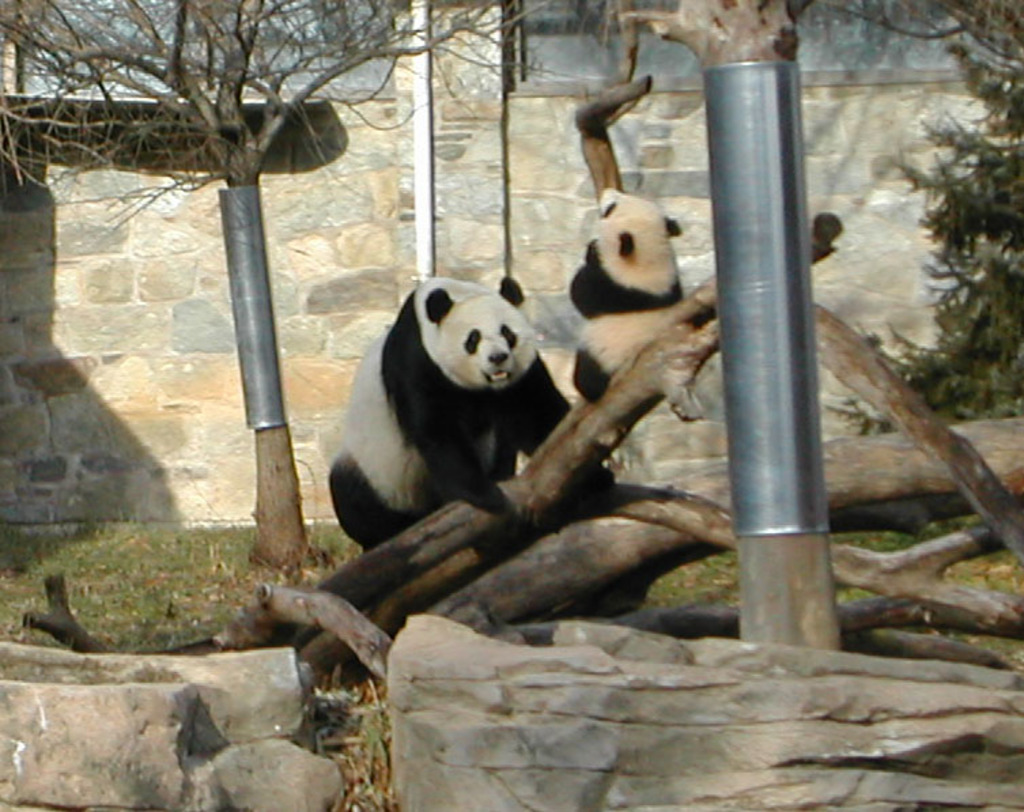

In [138]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

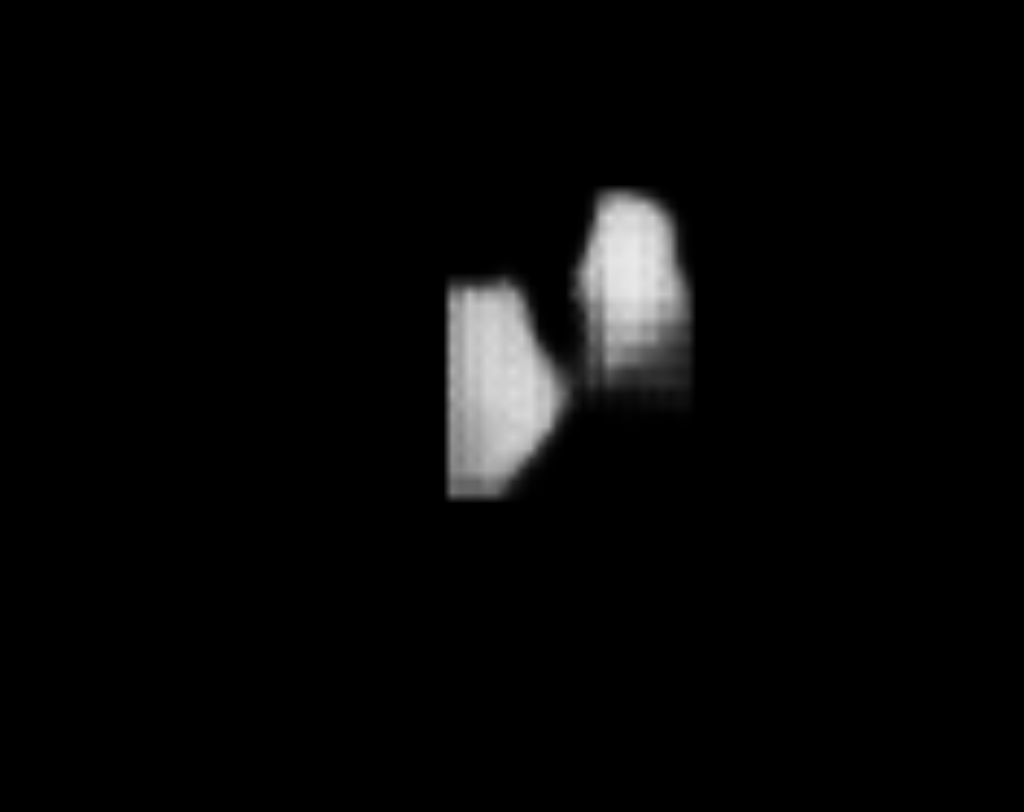

In [162]:
Image.fromarray(prediction[0]['masks'][4, 0].mul(255).byte().cpu().numpy())

og img shape = torch.Size([3, 812, 1024])
global_mask shape = torch.Size([1, 812, 1024])
global_mask : tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
pred_masks[0, 0] : tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')


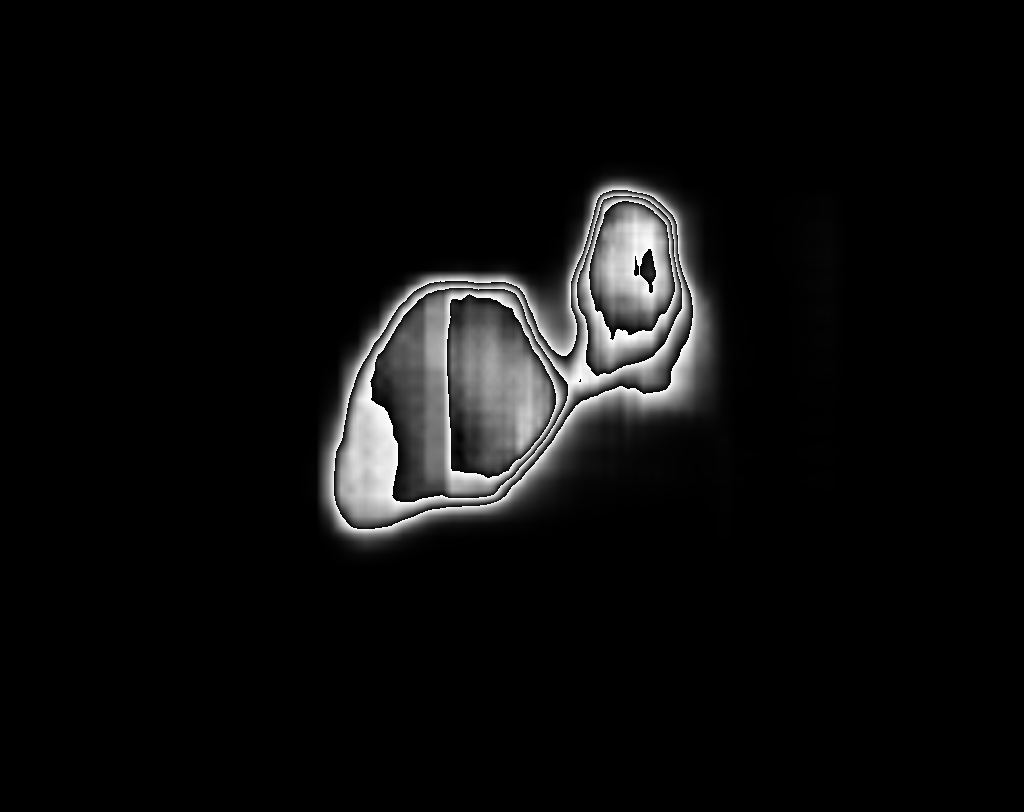

In [157]:
# this piece of code outputs a section of the predicted masks
# Image.fromarray(prediction[0]['masks'][4, 0].mul(255).byte().cpu().numpy())
pred_masks = prediction[0]['masks']
# now we want to iterate thru the masks and patch them into a single image
# get shape of mask images { should all have same shape as OG image }
# print(f"prediction[0]['masks'] \n{pred_masks}")

# create a tensor the same size as og image
# NOTE: og image has shape like (3, 812, 1042)
#   pred_masks have shape like (1, 812, 1042)
#   using pred_masks for global_mask for concatenating operations
# ? what does the first value in a tensor represent?
print(f"og img shape = {img.shape}")
global_mask = torch.zeros_like(pred_masks[0])
# global_mask = torch.as_tensor(global_mask, dtype=torch.uint8)
print(f"global_mask shape = {global_mask.shape}")
# print(f"global_mask device = {torch.device(global_mask)}")
# toggle pixels in global mask like
for mask in pred_masks:
  global_mask += mask
print(f"global_mask : {global_mask[0]}")
print(f"pred_masks[0, 0] : {pred_masks[0, 0]}")

Image.fromarray(global_mask[0].mul(255).byte().cpu().numpy())

Looks pretty good!

## Wrapping up

In this tutorial, you have learned how to create your own training pipeline for instance segmentation models, on a custom dataset.
For that, you wrote a `torch.utils.data.Dataset` class that returns the images and the ground truth boxes and segmentation masks. You also leveraged a Mask R-CNN model pre-trained on COCO train2017 in order to perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-gpu training, check `references/detection/train.py`, which is present in the [torchvision GitHub repo](https://github.com/pytorch/vision/tree/v0.8.2/references/detection). 



In [ ]:
# # old code, keep for ref
# from bson.int64 import Int64
# view = dataset.select_fields("ground_truth")

# # print(view)
# for sample in view:
#   # for each sample
#     # there is a array of detection objects
#     # for each detection
#       # index each detection
#       # save mask array with index instead of true values
#       # 
#   #print(np.array(sample))
#   if('0024ce778120b3d2' in sample.filepath):
#     image = Image.open(sample.filepath)
#     print(sample)
#     print(image.size)
#     imageWidth, imageHeight = image.size
#     print("imageWidth, imageHeight", imageWidth, imageHeight)
#     # this image size will be used to init the shape of the global mask
#     detections = sample.ground_truth.detections
#     #print(detections)
#     index = 1
#     # all detection masks has different size/shape
#     # init sample_mask with zeros and same shape as original image
#     # 
#     sample_mask = np.zeros(image.size, dtype=Int64)
#     print("sample_mask.shape => ", sample_mask.shape)
#     for detection in detections:

#       # print('detection.mask.shape', detection.mask.shape)
#       # multiply each numpy array by index for distinct frames per image
#       detection.mask = detection.mask * index
#       print(detection.mask)
#       print('detection.mask.shape', detection.mask.shape)
#       # get bounding box coords
#       bounding_box_coords = detection.bounding_box
#       print(bounding_box_coords)
#       # bb coords like:
#       # [<top-left-x>, <top-left-y>, <width>, <height>]
#       # FiftyOne stores box coordinates as floats in [0, 1] relative to 
#         # the dimensions of the image
#       # x1 = <top-left-x> * image_width, x2 = <width> * image_width + x1, 
#       # y1 = <top-left-y> * image_height, y2 = <height> * image_height + y1
#       (topLeftX, topLeftY, width, height) = bounding_box_coords
#       print("topLeftX, topLeftY, width, height", topLeftX, topLeftY, width, height)
#       width = width * imageWidth
#       height = height * imageHeight
      
#       xmin = round(topLeftX * imageWidth)
#       ymin = round(topLeftY * imageHeight)
#       xmax = round(xmin + width)
#       ymax = round(ymin + height)
#       print("xmin, ymin, xmax, ymax: ", xmin, ymin, xmax, ymax)
#       # Iterate over bounding box coordinates and corresponding mask arrays
#       # Slice empty numpy array and assign corresponding mask array
#       #sample_mask[ymin:ymax, xmin:xmax] = detection.mask
#       # increment index
#       index += 1
#       # sample_mask += detection.mask
#       # add each detection mask together
#       print(detection.mask)
#     # print(sample_mask)
#     #Image.open(sample.filepath)
# #sample = dataset['63f65cbdbf37b8e183debefd']

# # ChatGPT adjusted code to store a global_mask image for each sample 
# # Create empty numpy array with the same size as the final global mask image
# global_mask = np.zeros((500, 500), dtype=np.uint8)

# # Example of smaller mask arrays and bounding box coordinates
# mask_1 = np.ones((100, 100), dtype=np.uint8)
# bbox_1 = (100, 100, 200, 200)  # (xmin, ymin, xmax, ymax)

# mask_2 = np.ones((150, 150), dtype=np.uint8)
# bbox_2 = (250, 250, 400, 400)

# mask_3 = np.ones((50, 50), dtype=np.uint8)
# bbox_3 = (300, 100, 350, 150)

# # Iterate over bounding box coordinates and corresponding mask arrays
# for mask, bbox in zip([mask_1, mask_2, mask_3], [bbox_1, bbox_2, bbox_3]):
#     xmin, ymin, xmax, ymax = bbox
#     # Slice empty numpy array and assign corresponding mask array
#     global_mask[ymin:ymax, xmin:xmax] = mask

# # Combine all mask arrays into final global mask image
# final_mask = np.logical_or.reduce(global_mask)


# # get segm mask for image
# #detections = sample.ground_truth.detections

# #print(detections)
# #masks = []
# #for detection in detections:
#   #print(detection.mask)
#   #masks.append(detection.mask)
# # convert mask array to a numpy array
# #print(masks)
# # save mask as image
# #mask_file_path = "/content"